In [4]:
from qiskit import BasicAer

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType 
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

In [10]:
import numpy as np
import pylab

h2o = 'H; O 1 1.08; H 2 {} 1 104.5'
algorithms = ['VQE', 'ExactEigensolver']

pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
#distances = [x * 0.01 + 1.00 for x in range(17)]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, distance in enumerate(pts):
    print(i)
    for j in range(len(algorithms)):
        driver = PySCFDriver(h2o.format(distance), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                                two_qubit_reduction=True, freeze_core=True)
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'ExactEigensolver':
            #result = ExactEigensolver(qubit_op).run()
            result = ExactEigensolver(qubit_op, aux_operators=aux_ops).run()
        else:
            optimizer = SLSQP(maxiter=2500)
            init_state = HartreeFock(num_qubits=qubit_op.num_qubits, 
                                     num_orbitals=operator._molecule_info['num_orbitals'],
                                     num_particles=operator._molecule_info['num_particles'],
                                     qubit_mapping=operator._qubit_mapping,
                                     two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(num_qubits=qubit_op.num_qubits,
                             depth=1,
                             num_orbitals=operator._molecule_info['num_orbitals'], 
                             num_particles=operator._molecule_info['num_particles'],
                             qubit_mapping=operator._qubit_mapping,
                             two_qubit_reduction=operator._two_qubit_reduction, 
                             initial_state=init_state)
            algo = VQE(qubit_op, var_form, optimizer)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
        lines, result = operator.process_algorithm_result(result)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        if algorithms[j] == 'VQE':
            eval_counts[i] = result['algorithm_retvals']['eval_count']
    #distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step __0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
 --- complete
Distances:  [1.72723371e-077 2.32036210e+077 7.90505033e-323 0.00000000e+000
 2.01589600e-312 5.02034658e+175 5.73728030e+174 2.61266052e-057
 6.34435092e-066 1.04085097e-042 1.47763641e+248 1.16096346e-028
 7.69165785e+218 1.35617292e+248 6.21063611e-038 1.10593007e-046
 3.38147320e-061 1.95451295e+184 4.30621354e-096 6.32299154e+233
 6.48224638e+170 5.22411352e+257 5.74020278e+180]
Energies: [[-74.55901665 -74.81693134 -74.94311308 -74.99944901 -75.01742385
  -75.01416567 -74.99979751 -74.98050015 -74.95994873 -74.94023762
  -74.92252253 -74.9073896  -74.89502867 -74.88532937 -74.87797673
  -74.8671312  -74.86254799 -74.86072632 -74.85966737 -74.85964364
  -74.85965951 -74.85965854 -74.85953593]
 [-74.55909138 -74.81701354 -74.94320704 -74.99955788 -75.01755036
  -75.01431156 -74.99996286 -74.98068211 -74.96014207 -74.94043559
  -74.92271708 -74.90757295 -74.89519489 -74.88547475 -74.87809943
 

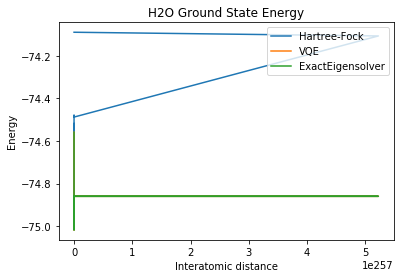

In [11]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2O Ground State Energy')
pylab.legend(loc='upper right');